# Estudio de la cinemática del IRB140 
usando robotics toolbox-python

In [20]:
# Hacemos todas las importaciones necesarias
# numpy para manejar array y algebra lineal
import numpy as np
import scipy as sc
# la funcionalidad específica de robótica está en el toolbox
import roboticstoolbox as rtb
# spatialmath tiene define los grupos de transformaciones especiales: rotación SO3 y eculideo SE3
import spatialmath as sm
import spatialmath.base.symbolic as sym
import matplotlib.pyplot as plt  

# %matplotlib qt

In [21]:
# Cargamos la definición del robot
irb140_rtb = rtb.models.DH.IRB140()

# Mostramos los parámetros cinemáticos y los dinámicos
print(irb140_rtb)
print(irb140_rtb.dynamics())

DHRobot: IRB 140 (by ABB), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌────┬───────┬──────┬────────┬─────────┬────────┐
│θⱼ  │  dⱼ   │  aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├────┼───────┼──────┼────────┼─────────┼────────┤
│ q1 │ 0.352 │ 0.07 │ -90.0° │ -180.0° │ 180.0° │
│ q2 │     0 │ 0.36 │   0.0° │ -100.0° │ 100.0° │
│ q3 │     0 │    0 │ -90.0° │ -220.0° │  60.0° │
│ q4 │  0.38 │    0 │  90.0° │ -200.0° │ 200.0° │
│ q5 │     0 │    0 │ -90.0° │ -120.0° │ 120.0° │
│ q6 │ 0.065 │    0 │   0.0° │ -400.0° │ 400.0° │
└────┴───────┴──────┴────────┴─────────┴────────┘

┌─┬──┐
└─┴──┘

┌─────┬─────┬──────┬───────┬─────┬──────┬──────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5   │
├─────┼─────┼──────┼───────┼─────┼──────┼──────┤
│  qr │  0° │ -90° │  90°  │  0° │  90° │ -90° │
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0°  │
│  qd │  0° │ -90° │  180° │  0° │  0°  │ -90° │
└─────┴─────┴──────┴───────┴─────┴──────┴──────┘

┌──────┬───────┬─────────────────────────────────┬─

   0.2075   -0.1358   -0.9688   -0.001578  
  -0.6451   -0.7635   -0.03112   0.0009565  
  -0.7354    0.6314   -0.246     0.04143   
   0         0         0         1         



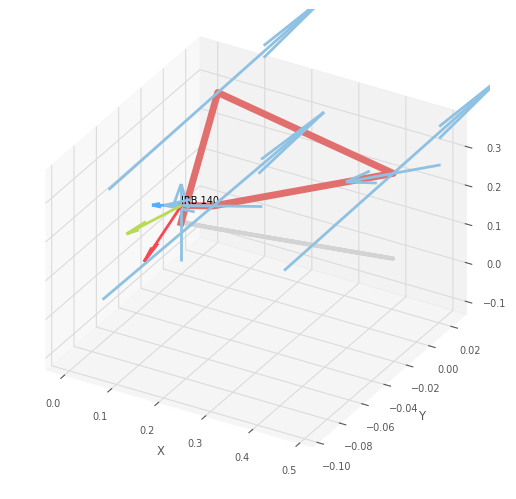

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'IRB 140')

<Figure size 640x480 with 0 Axes>

In [22]:
# Probamos la cinemática directa
qz = np.zeros(6)
qz = np.radians(np.random.rand(6)*45)
POSE = irb140_rtb.fkine(qz)
print(POSE)

irb140_rtb.plot(qz)

# Modelo desarrollado en clase

In [23]:
# Si comparamos con nuestro modelo hecho en clase notamos una diferencia en el signo de alfa3, alfa4 y alfa5
# Notamos también que la terna 0 la hizo coincidente a la base y que la 6 la puso en tool0
# Voy a definirlo según la asignación de ternas que vimos en clase, 
# ajustando los offsets para que los ángulos sean iguales a los de ABB
irb140 = rtb.DHRobot(
    [
        rtb.RevoluteDH(alpha=-np.pi/2,a=0.07),
        rtb.RevoluteDH(a=0.36,offset=-np.pi/2),
        rtb.RevoluteDH(alpha=np.pi/2,offset=np.pi),
        rtb.RevoluteDH(d=0.38, alpha=-np.pi/2),
        rtb.RevoluteDH(alpha=np.pi/2),
        rtb.RevoluteDH()
    ], name="IRB140")

print(irb140)

DHRobot: IRB140, 6 joints (RRRRRR), dynamics, standard DH parameters
┌───────────┬──────┬──────┬────────┐
│    θⱼ     │  dⱼ  │  aⱼ  │   ⍺ⱼ   │
├───────────┼──────┼──────┼────────┤
│ q1        │    0 │ 0.07 │ -90.0° │
│ q2 - 90°  │    0 │ 0.36 │   0.0° │
│ q3 + 180° │    0 │    0 │  90.0° │
│ q4        │ 0.38 │    0 │ -90.0° │
│ q5        │    0 │    0 │  90.0° │
│ q6        │    0 │    0 │   0.0° │
└───────────┴──────┴──────┴────────┘

┌─┬──┐
└─┴──┘



[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -0.3]
 [ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]]


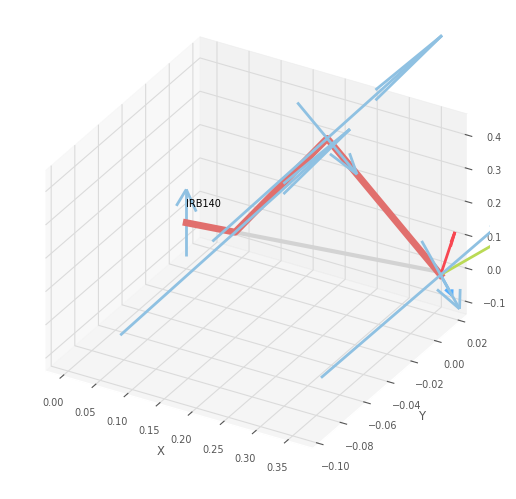

PCI:  [ 1.571 -2.665  0.525  0.     0.57  -1.571] 
Deseado:  [0.048 0.375 0.753 0.082 0.194 0.633]
Delta Q= [ 1.522 -3.041 -0.228 -0.082  0.376 -2.203]


<Figure size 640x480 with 0 Axes>

In [47]:
# Probamos el pcd
POSE = irb140.fkine(qz)
POSE = np.array([[1,0,0,0],
                 [0,1,0,-0.300],
                 [0,0,1,0],
                 [0,0,0,1]])
print(POSE)
irb140.plot(qz)

# Probamos el pci
q = irb140.ikine_LM(POSE)
print("PCI: ",q.q,"\nDeseado: ",qz)
print("Delta Q=",q.q-qz)

In [25]:
# Pongamos a prueba el pcd y pci_numerico haciendo evaluaciones sobre valores random de q
def probar_acierto_IK(flag_q0_cercano = False):
  n_acierto = 0
  n_iter = 100
  for i in range(1,n_iter):
    # q_deseado = irb140.qrandom
    q_deseado = np.radians(np.random.rand(6)*45)
    POSE = irb140.fkine(q_deseado)
    if flag_q0_cercano :
      ik_solucion = irb140.ikine_LM(POSE,q0=q_deseado+np.radians(np.random.rand(6)*45)/100, slimit=100) 
    else:
      ik_solucion = irb140.ikine_LM(POSE) 
    if np.linalg.norm(q_deseado-ik_solucion.q)<1E-3:
       n_acierto += 1
  print("Cantidad de corridas: ",n_iter,"\nCantidad de aciertos: ",n_acierto)

print("Probamos con q0 random ******** ")
probar_acierto_IK()
print("\nProbamos con q0 cercano ******** ")
probar_acierto_IK(True)


Probamos con q0 random ******** 
Cantidad de corridas:  100 
Cantidad de aciertos:  15

Probamos con q0 cercano ******** 
Cantidad de corridas:  100 
Cantidad de aciertos:  99


# Singularidades

Estudiamos las singularidades de la muñeca, el brazo y el codo usando el algoritmo de cálculo numérico del toolbox

In [26]:
# Evaluamos el jacobiano en la singularidad de la muñeca
np.set_printoptions(precision=3,suppress=True)
qsing = np.array([[0,0,0,0,0,0]])
J = irb140.jacob0(qsing)

print("J:\n",J)
print("J11:\n",J[0:3,0:3])
print("J12:\n",J[0:3,3:6])

print("Determinante: ",np.linalg.det(J))
print("Espacio Nulo de J:\n",sc.linalg.null_space(J))
print("Espacio Nulo de J transpuesto:\n",sc.linalg.null_space(J.transpose()))

# Se ve que no puede rotar en z0

J:
 [[-0.    0.36  0.    0.    0.    0.  ]
 [ 0.45  0.    0.    0.    0.    0.  ]
 [ 0.   -0.38 -0.38  0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    1.  ]
 [ 0.    1.    1.    0.    1.    0.  ]
 [ 1.    0.    0.    0.    0.    0.  ]]
J11:
 [[-0.    0.36  0.  ]
 [ 0.45  0.    0.  ]
 [ 0.   -0.38 -0.38]]
J12:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Determinante:  8.59527065895444e-67
Espacio Nulo de J:
 [[ 0.   ]
 [ 0.   ]
 [-0.   ]
 [-0.707]
 [ 0.   ]
 [ 0.707]]
Espacio Nulo de J transpuesto:
 [[ 0.   ]
 [-0.912]
 [-0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.41 ]]


In [27]:
# Evaluamos el jacobiano en la singularidad del brazo
# Para esto vamos a averiguar el q que lleva la muñeca a un punto del eje 1
POSE = sm.SE3.Trans(0,0,0.500)
print(POSE)
qsing = irb140.ikine_LM(POSE).q
print("q singular:",np.rad2deg(qsing))
J = irb140.jacob0(qsing)
print("Determinante: ",np.linalg.det(J))
print("Espacio Nulo de J:\n",sc.linalg.null_space(J))
print("Espacio Nulo de J transpuesto:\n",sc.linalg.null_space(J.transpose()))

   1         0         0         0         
   0         1         0         0         
   0         0         1         0.5       
   0         0         0         1         

q singular: [ 30.08   40.692 175.997 180.    -53.311 149.92 ]
Determinante:  2.084988107793604e-12
Espacio Nulo de J:
 []
Espacio Nulo de J transpuesto:
 []


In [28]:
# Lo anterior probablemente no anduvo!
print("POSE obtenida con PCI numérico:\n",irb140.fkine(qsing))
print("POSE deseada:\n",POSE)

# Verifico el índice de configuración:
print("Indice config1: ",irb140.a[0]+irb140.a[1]*np.cos(qsing[1]+irb140.offset[1])+irb140.d[3]*np.sin(qsing[1]+irb140.offset[1]+qsing[2]+irb140.offset[2]))


POSE obtenida con PCI numérico:
    1        -1.085e-07  4.752e-08 -1.649e-11  
   1.085e-07  1        -6.484e-08 -9.549e-12  
  -4.752e-08  6.484e-08  1         0.5       
   0         0         0         1         

POSE deseada:
    1         0         0         0         
   0         1         0         0         
   0         0         1         0.5       
   0         0         0         1         

Indice config1:  -1.9053036925953393e-11


In [29]:
# Despejo q3 para que   d4*s23= -a1-a2*c2   ... ojo con los offsets que definimos en los ejes
qsing_original = qsing 
qsing[2]=np.arcsin((-irb140.a[0]-irb140.a[1]*np.cos(qsing[1]+irb140.offset[1]))/irb140.d[3])-qsing[1]-irb140.offset[1]-irb140.offset[2]

print("q singular:\n",qsing)
print("Indice config1: ",irb140.a[0]+irb140.a[1]*np.cos(qsing[1]+irb140.offset[1])+irb140.d[3]*np.sin(qsing[1]+irb140.offset[1]+qsing[2]+irb140.offset[2]))

# Reviso la POSE alcanzada
print("POSE:\n",irb140.fkine(qsing))

J = irb140.jacob0(qsing)
print(J)
print("Determinante: ",np.linalg.det(J))
print("Espacio Nulo de J:\n",sc.linalg.null_space(J))
print("Espacio Nulo de J transpuesto:\n",sc.linalg.null_space(J.transpose()))


q singular:
 [ 0.525  0.71  -3.211  3.142 -0.93   2.617]
Indice config1:  -1.1102230246251565e-16
POSE:
    1        -1.085e-07  4.759e-08  0         
   1.085e-07  1        -6.479e-08  0         
  -4.759e-08  6.479e-08  1         0.5       
   0         0         0         1         

[[ 0.     0.433  0.196  0.     0.     0.   ]
 [-0.     0.251  0.114  0.     0.     0.   ]
 [-0.     0.07   0.305  0.     0.     0.   ]
 [ 0.    -0.501 -0.501 -0.694  0.501  0.   ]
 [-0.     0.865  0.865 -0.402 -0.865 -0.   ]
 [ 1.     0.     0.     0.597 -0.     1.   ]]
Determinante:  3.7700140115760986e-18
Espacio Nulo de J:
 [[-0.707]
 [ 0.   ]
 [-0.   ]
 [ 0.   ]
 [-0.   ]
 [ 0.707]]
Espacio Nulo de J transpuesto:
 [[-0.501]
 [ 0.865]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]]


In [30]:
# Veamos mejor los valores singulares:
# Notamos que la ultima fila de Vt da null(J)
# y que la ultima columna de U da null(J_transpuesta)
np.set_printoptions(precision=3,suppress=True)
U,S,Vt = sc.linalg.svd(J)
print("Valores Singulares: ",S)
print("V transpuesta: \n",Vt)
print("U: \n",U)

Valores Singulares:  [1.798 1.575 0.72  0.345 0.22  0.   ]
V transpuesta: 
 [[-0.     0.608  0.587 -0.    -0.535 -0.   ]
 [ 0.614  0.     0.     0.495 -0.     0.614]
 [-0.35   0.     0.     0.869  0.    -0.35 ]
 [ 0.     0.663 -0.004 -0.     0.748  0.   ]
 [ 0.    -0.437  0.81  -0.     0.392  0.   ]
 [-0.707  0.    -0.     0.    -0.     0.707]]
U: 
 [[ 0.21   0.     0.     0.828 -0.136 -0.501]
 [ 0.122  0.     0.     0.48  -0.079  0.865]
 [ 0.123  0.     0.     0.131  0.984 -0.   ]
 [-0.482 -0.218 -0.837  0.13   0.043  0.   ]
 [ 0.833 -0.126 -0.485 -0.224 -0.074  0.   ]
 [-0.     0.968 -0.252  0.     0.     0.   ]]


In [31]:
# Vuelvo a intentar recuperar los espacios nulos usando la solución aproximada
J = irb140.jacob0(qsing_original)

U,S,Vt = sc.linalg.svd(J)
print("Valores Singulares: ",S)
print("Velocidades en los ejes que no van a producir velocidades cartesianas")
print("Espacio Nulo de J:\n",Vt[-1,:])
print("esas direcciones no pueden ser recorridas cuando se esta en la singularidad ")
print("Espacio Nulo de J transpuesto:\n",U[:,-1])

Valores Singulares:  [1.798 1.575 0.72  0.345 0.22  0.   ]
Velocidades en los ejes que no van a producir velocidades cartesianas
Espacio Nulo de J:
 [-0.707  0.    -0.     0.    -0.     0.707]
esas direcciones no pueden ser recorridas cuando se esta en la singularidad 
Espacio Nulo de J transpuesto:
 [-0.501  0.865 -0.     0.     0.     0.   ]


In [32]:
# Evaluamos la singularidad del codo
# qsing = irb140.qrandom
qsing = np.radians(np.random.rand(6)*45)
qsing = np.array([0,-np.pi/2,0,0,0,0])
qsing[2] = -np.pi/2

J = irb140.jacob0(qsing)

U,S,Vt = sc.linalg.svd(J)
print("Valores Singulares: ",S)
print("Espacio Nulo de J:\n",Vt[-1,:])
print("Espacio Nulo de J transpuesto:\n",U[:,-1])


Valores Singulares:  [1.859 1.414 1.204 0.488 0.    0.   ]
Espacio Nulo de J:
 [ 0.     0.011 -0.021 -0.707  0.01   0.707]
Espacio Nulo de J transpuesto:
 [ 0.786  0.514 -0.     0.    -0.     0.344]


In [33]:
# No dice demasiado, Lo mejor sería proyectar la velocidad en terna 3
# En este caso la dirección prohibida debería ser z_3
POSE = irb140.fkine_all(qsing)
print(POSE)
R_03 = POSE[3].R
# @ multiplicacion entre dos matrices
R_03.transpose() @ U[0:3,-1].transpose()

[0] =
   1         0         0         0         
   0         1         0         0         
   0         0         1         0         
   0         0         0         1         
[1] =
   1         0         0         0.07      
   0         0         1         0         
   0        -1         0         0         
   0         0         0         1         
[2] =
  -1         0         0        -0.29      
   0         0         1         0         
   0         1         0         0         
   0         0         0         1         
[3] =
   0         0        -1        -0.29      
   0         1         0         0         
   1         0         0         0         
   0         0         0         1         
[4] =
   0         1         0        -0.67      
   0         0         1         0         
   1         0         0         0         
   0         0         0         1         
[5] =
   0         0        -1        -0.67      
   0         1         0         0      

array([-0.   ,  0.514, -0.786])

# Ejercicio

Graficar el perfil de posiciones articulares y espaciales (solo posición) para un movimiento en línea recta en la dirección Y_0

In [54]:
# Resolución
# Primero armamos una función que simule el movimiento, porque al estudiar distintos
# casos es mejor no repetir código

def simular_movimiento(POSE_ini,POSE_fin,salida,tiempo_mov=1,n_steps=200):
  # Inicializo las variables que definen el movimiento deseado
  dx = (POSE_fin.t - POSE_ini.t)/n_steps
  dx = dx.reshape(3,1)
  dw = np.zeros((3,1))
  dt = tiempo_mov/n_steps

  # Inicializo las variables que uso luego para graficar
  q_acum = np.empty((n_steps,6))
  qp_acum = np.empty((n_steps,6))
  X_acum = np.empty((n_steps,3))

  # Simulo el movimiento
  q = irb140.ikine_LM(POSE_ini).q
  for idx_step in range(n_steps):
    # Caso general
    J = irb140.jacob0(q)
    J_pinv = sc.linalg.pinv(J)  
    V = np.vstack((dx,dw))/dt
    qp = np.reshape(J_pinv @ V, (6,))
    
    # En este caso no nos preocupamos por mantener la orientación
  #  J = irb140.jacob0(q)[0:3,:]
  #  J_pinv = sc.linalg.pinv(J)  
  #  V = dx/dt
  #  qp = np.reshape(J_pinv @ V, (6,))

    # En este caso no nos preocupamos por la trayectoria en X0  
  #  J = irb140.jacob0(q)[1:-1,:]
  #  J_pinv = sc.linalg.pinv(J)  
  #  V = np.vstack((dx[1,-1],dw))/dt
  #  qp = np.reshape(J_pinv @ V, (6,))

    q = q + qp *dt
    q_acum[idx_step,:] = q
    qp_acum[idx_step,:] = qp
    X_acum[idx_step,:] = np.reshape(irb140.fkine(q).t,(1,3))

  # Grafico resultados
  #trayectoria = irb140.fkine(q_acum) 
  irb140.plot(q_acum, backend='pyplot', movie= salida + '.gif')
    
  # t = np.linspace(0,1,n_steps)
  t = np.linspace(0,tiempo_mov,n_steps)
  plt.subplot(2,1,1)
  plt.plot(t, q_acum*180/np.pi)
  plt.title('Posiciones articulares')
  plt.xlabel('Tiempo [s]')
  plt.ylabel('$q(t)$ [°]')
  plt.legend(['$q_1$','$q_2$','$q_3$','$q_4$','$q_5$','$q_6$'])
  plt.show()

  plt.subplot(2,1,2)
  plt.plot(t, qp_acum*180/np.pi)
  plt.title('Velocidades articulares')
  plt.xlabel('Tiempo [s]')
  plt.ylabel('$\dot{q}(t)$ [°/s]')
  plt.legend(['$\dot{q}_1$','$\dot{q}_2$','$\dot{q}_3$','$\dot{q}_4$','$\dot{q}_5$','$\dot{q}_6$'])
  plt.show()

  plt.plot(t,X_acum[:,:]*1000)
  plt.title('Posiciones cartesianas')
  plt.xlabel('Tiempo [s]')
  plt.ylabel('POS [mm]')
  plt.legend(['$x$', '$y$','$z$'])
  plt.show()
    
    



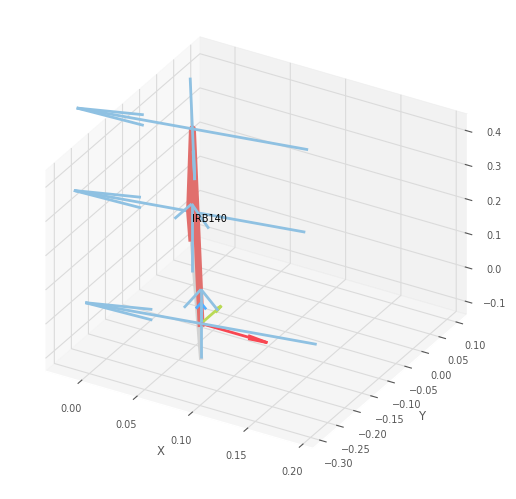

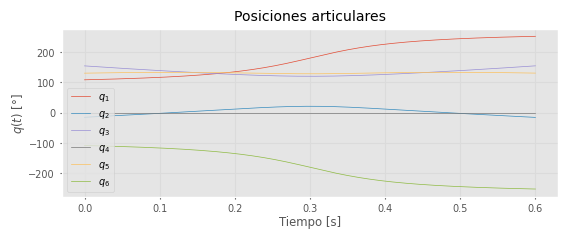

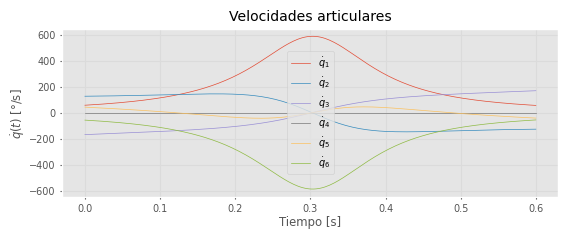

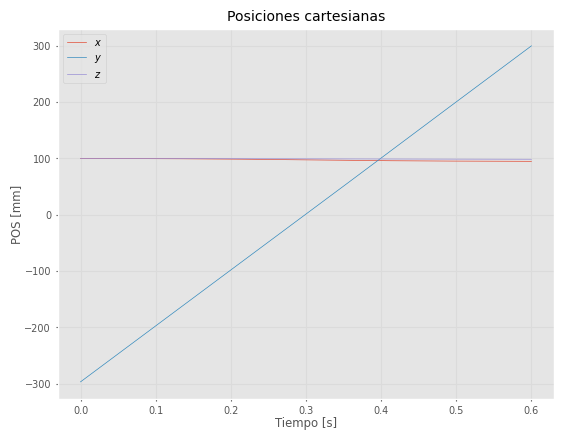

In [60]:
# Esto pasa por la singularidad del brazo
%matplotlib inline
# POSE_ini = sm.SE3.Trans(0.01,-0.100,0.5)
# POSE_fin = sm.SE3.Trans(0.01,0.100,0.5)
POSE_ini = sm.SE3.Trans(0.1,-0.300,0.1)
POSE_fin = sm.SE3.Trans(0.1,0.300,0.1)
simular_movimiento(POSE_ini,POSE_fin,"irb140trayec1",tiempo_mov=0.6)


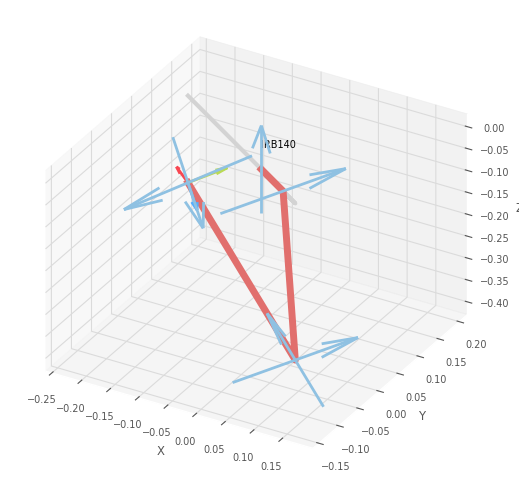

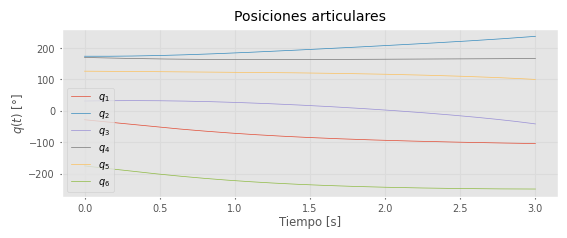

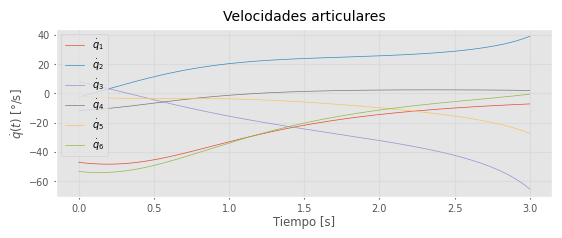

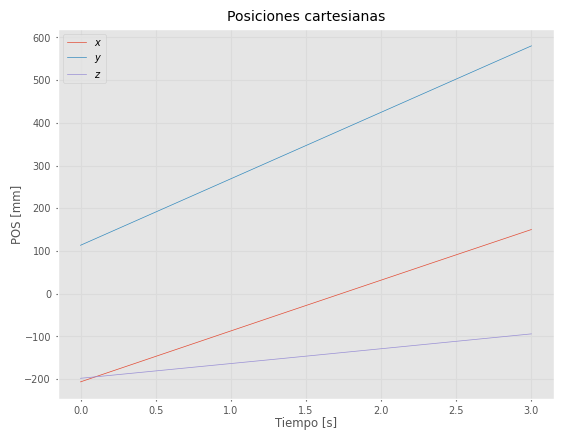

In [61]:
# Esto pasa por la singularidad de la muñeca
POSE_zero = irb140.fkine(qz)
POSE_ini = POSE_zero * sm.SE3(0.530,-0.300,0.0469)
POSE_fin = POSE_zero * sm.SE3(0.530,0.300,0.0469)
simular_movimiento(POSE_ini,POSE_fin,"irb140trayec2")

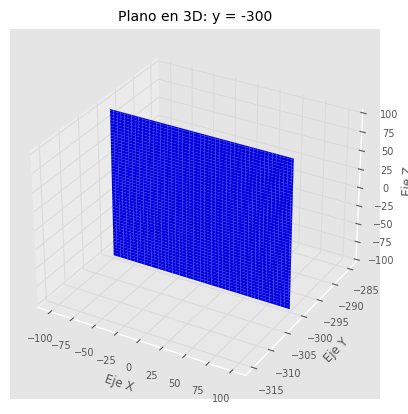

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Valores de los ejes X y Z
x = np.linspace(-100, 100, 100)  # Rango en el eje X
z = np.linspace(-100, 100, 100)  # Rango en el eje Z

# Crear una malla de puntos X y Z
X, Z = np.meshgrid(x, z)

# Valor constante para el eje Y
Y = np.full_like(X, -300)

# Graficar el plano
# ax.plot_surface(X, Y, Z, cmap='none')
ax.plot_surface(X, Y, Z, color = 'blue')

# Personalizar la gráfica (opcional)
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
ax.set_title('Plano en 3D: y = -300')

# Mostrar la gráfica
plt.show()
